# Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [2]:
from fastai import *

In [3]:
path = untar_data(URLs.PETS)

In [7]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [4]:
path_hr = path/'images'
path_lr = path/'crappy'

## Crapified Data

We'll prepare the input data by doing some random disfigurations (or crappifications) in the input data

In [5]:
from PIL import Image, ImageDraw, ImageFont

Just draw something random on the image and drop its quality

In [6]:
def crappify(fn, i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents = True, exist_ok = True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample = PIL.Image.BILINEAR).convert('RGB')
    w, h = img.size
    q = random.randint(10, 70)
    ImageDraw.Draw(img).text((random.randint(0, w//2), random.randint(0, h//2)), str(q), fill = (255, 255, 255))
    img.save(dest, quality = q)

Uncomment if you're running it for the first time

In [7]:
#il = ImageItemList.from_folder(path_hr)
#parallel(crappify, il.items)

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/images')]

In [9]:
bs, size = 32, 128
arch = models.resnet34

## Pre-train the Generator

In [10]:
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed = 42)

In [11]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom = 2.), size = size, tfm_y = True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y = True))
    
    data.c = 3
    return data

In [12]:
data_gen = get_data(bs, size)

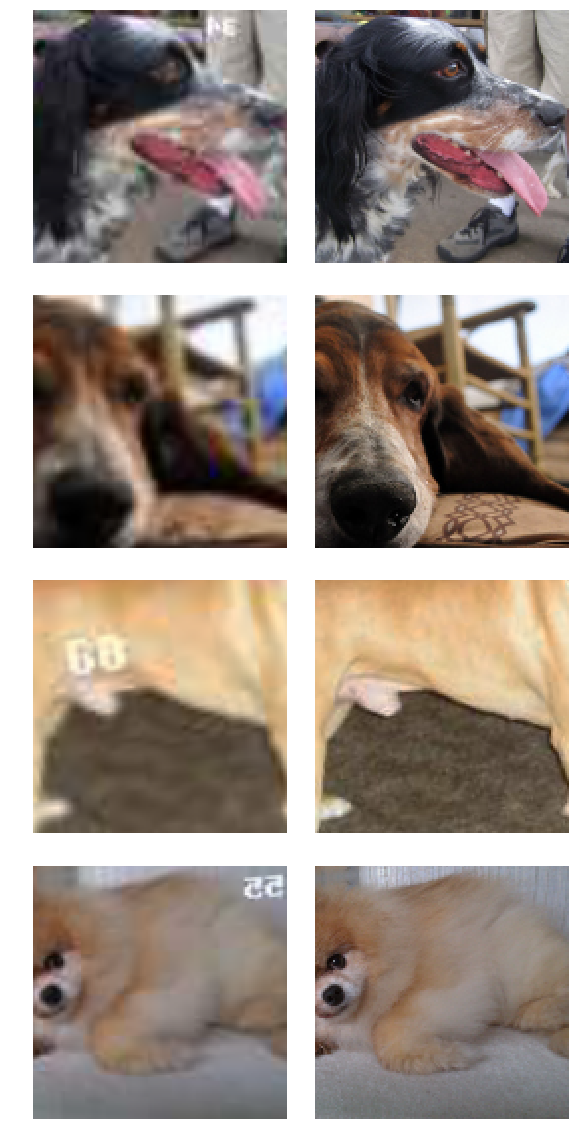

In [13]:
data_gen.show_batch(4)

In [14]:
wd = 1e-3

In [23]:
#y_range = (-3., 3.)
# This is removed because it was creating an error in unet_learner()
# [TODO]

In [16]:
loss_gen = MSELossFlat()

In [20]:
# blur, norm_type and self_attention would be covered in part 2
def create_gen_learner():
    return unet_learner(data_gen, arch, wd = wd, blur = True, norm_type = NormType.Weight,
                       self_attention = True, loss_func = loss_gen)

In [21]:
learn_gen = create_gen_learner()

In [22]:
learn_gen.fit_one_cycle(2, pct_start = 0.8)

epoch,train_loss,valid_loss
1,0.442330,0.368294
2,0.186786,0.147652


In [24]:
learn_gen.unfreeze()

In [25]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss
1,0.132239,0.110968
2,0.095150,0.075666
3,0.082296,0.064168


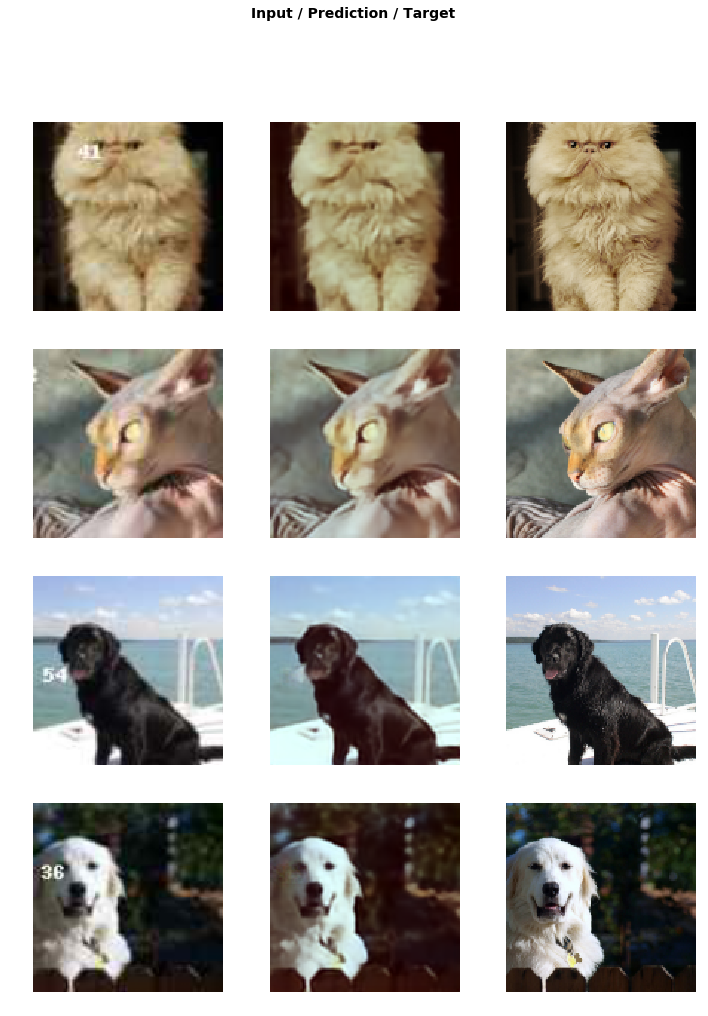

In [26]:
learn_gen.show_results(rows = 4)

In [27]:
learn_gen.save('gen-pre2')

## Save generated Images

Notice that in the above results, we see that random data is successfully detected and corrected, however, the output is not quite upto the mark when compared with the high-resolution images on the right-most side.

This is solved by using a method called "Generative Adversarial Model" where we train a adversary/discriminator/critic so that it learn from the generator and improve the model

In [28]:
learn_gen.load('gen-pre2');

In [29]:
name_gen = 'image-gen'
path_gen = path/name_gen

In [31]:
path_gen.mkdir(exist_ok = True)

In [48]:
def save_preds(dl): # Save predictions from our dataloader
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch = b)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [49]:
save_preds(data_gen.single_dl)

AttributeError: 'Tensor' object has no attribute 'save'

In [44]:
data_gen.single_dl.dataset.items

array([PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Persian_87.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Sphynx_14.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/newfoundland_71.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/great_pyrenees_32.jpg'), ...,
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/english_cocker_spaniel_84.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/Abyssinian_66.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/scottish_terrier_5.jpg'),
       PosixPath('/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/english_setter_30.jpg')], dtype=object)

In [47]:
doc(learn_gen.pred_batch)